# Implementing Sparse Matrix Vector Multiplication (CSR Compression Format) on the FPGA Cluster

In [2]:
# MLab UDMA library
import hyperfpga_cluster as hfc
import waveforms

import time
import tracemalloc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Assigned Nodes: ['hyperfpga-3be11-2-1']


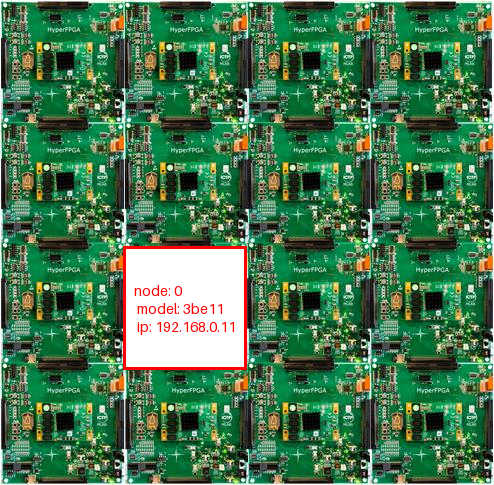

In [3]:
nodes = hfc.get_nodes()
nodes = hfc.get_nodes(view = True)

In [4]:
nodes = hfc.get_nodes()
test_node = nodes[0]
cluster = hfc.HyperFPGACluster(nodes=test_node, firmware='CSR512', n_engines=1, engines_per_node=1) #512x512 perfect
cluster.create_profile()
await cluster.configure()

Assigned Nodes: ['hyperfpga-3be11-2-1']
Profile exists, rewritting configuration.
Uploading firmware...
b'/home/jupyter-kaust_ghala/Getting_Started/bitstreams/CSR512-3be11.dtbo' -> b'' 000.00.61
 Programming fpgas...
Time taken to load BIN is 178.000000 Milli Seconds
BIN FILE loaded through FPGA manager successfully

 Node Status
 host: hyperfpga-3be11-2-1 state: operating
 firmware: CSR512 comblock: ['fifo_i', 'fifo_o', 'regs_i', 'regs_o']



In [5]:
remote_client = cluster.start_and_connect_sync()
dview = remote_client[:]
dview.execute("""
from comblock import Comblock
cb = Comblock()""")

Starting 1 engines with <class 'ipyparallel.cluster.launcher.SSHEngineSetLauncher'>
ensuring remote mlabadm@192.168.0.11:.ipython/profile_ssh/security/ exists
sending /home/jupyter-kaust_ghala/.ipython/profile_ssh/security/ipcontroller-1754570432-o5bw-client.json to mlabadm@192.168.0.11:.ipython/profile_ssh/security/ipcontroller-1754570432-o5bw-client.json
ensuring remote mlabadm@192.168.0.11:.ipython/profile_ssh/security/ exists
sending /home/jupyter-kaust_ghala/.ipython/profile_ssh/security/ipcontroller-1754570432-o5bw-engine.json to mlabadm@192.168.0.11:.ipython/profile_ssh/security/ipcontroller-1754570432-o5bw-engine.json
Running `python3 -m ipyparallel.engine --profile-dir=/home/mlabadm/.ipython/profile_ssh`
100%|██████████| 1/1 [00:10<00:00, 10.10s/engine]


<AsyncResult(execute): pending>

In [6]:
def generate_matrix(rows, cols):
    matrix = np.zeros((rows, cols), dtype=int)
    for i in range(rows):
        for j in range(cols):
            if (i + j) % 5 == 0:  # Sparse pattern
                matrix[i][j] = (i + j) % 10 + 1
    return matrix

def generate_vector(size):
    return [(i % 10) + 1 for i in range(size)]

def to_csr(matrix):
    values = []
    col_index = []
    row_ptr = [0]
    nnz = 0
    for row in matrix:
        for j, val in enumerate(row):
            if val != 0:
                values.append(val)
                col_index.append(j)
                nnz += 1
        row_ptr.append(nnz)
    return row_ptr, col_index, values

A = generate_matrix(512, 512)
x = generate_vector(512)
row_ptr, col_index, values = to_csr(A)


data_in = row_ptr + col_index + values + x
#print(len(values)) # check total nnz

In [13]:
@dview.remote(block=True)
def run_spmv(data_in):
    cb.fifo_out_clear()
    cb.fifo_in_clear()

    cb.write_reg(0, 1)
    for val in data_in:
        cb.write_fifo(int(val))
    
    result = cb.read_fifo(512)

    cb.write_reg(0, 0)
    
    return result

print(run_spmv(data_in))
#print(len(run_spmv(data_in)[0]))

[[1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 1683, 1326, 981, 618, 3315, 2958, 2601, 2246, 1888, 2040, 

In [7]:
performance_data = []
def measure_performance(name, input_size):
    def decorator(func):
        def wrapper(*args, **kwargs):
            tracemalloc.start()
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            exec_time = end - start
            peak_kb = peak / 1024
            print(f"{name} | Input: {input_size} | Computation: {exec_time:.6f}s | Memory: {peak_kb:.2f} KB")
            performance_data.append({
                "Algorithm": name,
                "Input": input_size,
                "Computation Time (s)": exec_time,
                "Memory (KB)": peak_kb
            })
            return result
        return wrapper
    return decorator

In [8]:
@measure_performance("CSR", 512)
def run_csr2():
    return run_spmv(data_in)

# Transmission time
tx_start = time.perf_counter()
result = run_csr2()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time

print(f"CSR | Transmission Time: {transmission_time:.6f}s")

CSR | Input: 512 | Computation: 5.838851s | Memory: 10156.06 KB
CSR | Transmission Time: 0.002164s


In [9]:
df = pd.DataFrame(performance_data)
print(df)

  Algorithm  Input  Computation Time (s)   Memory (KB)  Transmission Time (s)
0       CSR    512              5.838851  10156.064453               0.002164


In [10]:
await cluster.clean_cluster()